--- Starting AURA Performance Benchmark ---

[ Benchmarking Dataset: advanced_iot.csv ]
  -> Training learner to find optimal parameters...
  -> Learner found optimal params: Threshold=0.9514, Duration=143
  -> Running simulation for 2500 timesteps...
  -> Results: Power Saved = 84.61%, Fidelity = 99.35%

[ Benchmarking Dataset: cleaned_iot_data.csv ]
  -> Training learner to find optimal parameters...
  -> Learner found optimal params: Threshold=0.9425, Duration=185
  -> Running simulation for 2500 timesteps...
  -> Results: Power Saved = 56.84%, Fidelity = 99.23%

[ Benchmarking Dataset: daily_temperature_1000_cities.csv ]
  -> Training learner to find optimal parameters...
  -> Learner found optimal params: Threshold=0.9995, Duration=127
  -> Running simulation for 2500 timesteps...
  -> Results: Power Saved = 98.35%, Fidelity = 99.99%

[ Benchmarking Dataset: factory_sensor_simulator.csv ]
  -> Training learner to find optimal parameters...
  -> Learner found optimal params: Thresh

C:\Users\Augustine\AppData\Local\Temp\ipykernel_6756\4180295733.py:126: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


  -> Training learner to find optimal parameters...
  -> Learner found optimal params: Threshold=0.9131, Duration=193
  -> Running simulation for 2500 timesteps...
  -> Results: Power Saved = 67.76%, Fidelity = 99.32%

[ Benchmarking Dataset: iot_telemetry_data.csv ]
  -> Training learner to find optimal parameters...
  -> Learner found optimal params: Threshold=0.9548, Duration=177
  -> Running simulation for 2500 timesteps...
  -> Results: Power Saved = 49.65%, Fidelity = 99.21%

--- Benchmark Complete in 71.71 seconds ---

--- Benchmark Results Summary ---
+-----------------------------------+-------------------+----------------+
| Dataset                           | Power Saved (%)   | Fidelity (%)   |
+===================================+===================+================+
| advanced_iot.csv                  | 84.61             | 99.35          |
+-----------------------------------+-------------------+----------------+
| cleaned_iot_data.csv              | 56.84             | 9

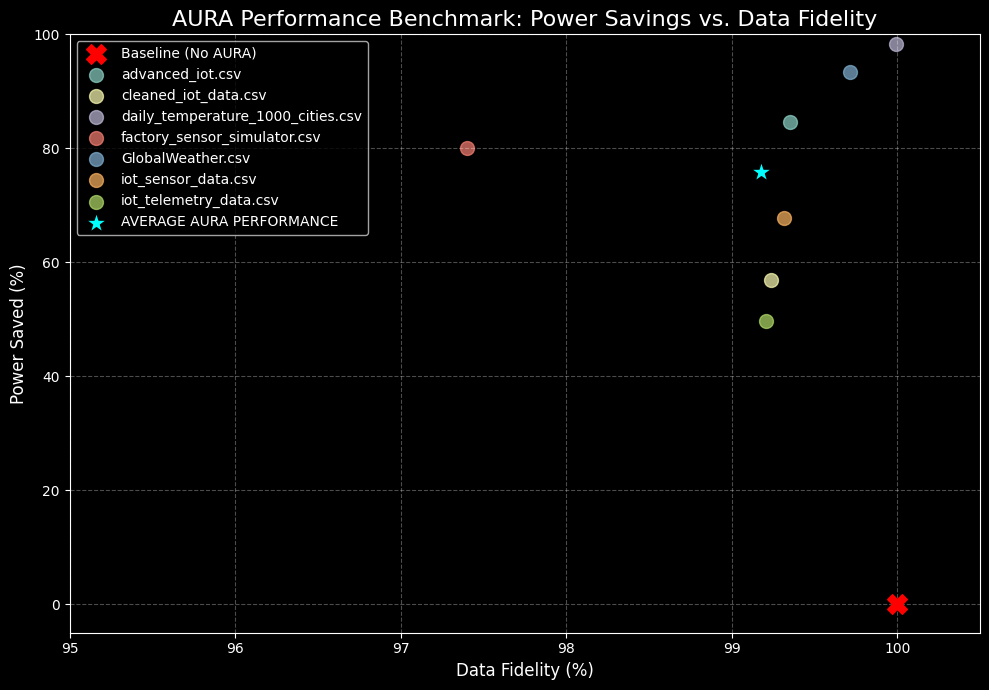

In [11]:
import pandas as pd
import numpy as np
from scipy.optimize import differential_evolution
from numba import njit
from itertools import combinations
import matplotlib.pyplot as plt
from tabulate import tabulate
import time

# --- Configuration ---
# Add the filenames of the CSV datasets you want to benchmark here.
# The script will automatically handle dropping a 'date' column if it exists.
DATASET_FILES = [
    'advanced_iot.csv',
    'cleaned_iot_data.csv',
    'daily_temperature_1000_cities.csv',
    'factory_sensor_simulator.csv',
    'GlobalWeather.csv',
    'iot_sensor_data.csv',
    'iot_telemetry_data.csv',
    # 'Occupancey.csv'
]
SIMULATION_TIMESTEPS = 2500

# --- Manual Parameter Control ---
# Set USE_LEARNER to False to use the manual parameters below.
# Set USE_LEARNER to True to let the AI find the optimal parameters for each dataset.
USE_LEARNER = True

# These values are only used if USE_LEARNER is set to False.
MANUAL_THRESHOLD = 0.98
MANUAL_DURATION = 40


# --- Core AURA Algorithm Logic (Copied from the backend) ---

@njit
def generalized_redundancy_metric(readings, n):
    if n < 2: return 0.0
    total = np.sum(readings)
    if total <= 1e-9: return 0.0
    denominator = n * (np.sin(np.pi / n)**2)
    if denominator < 1e-9: return 0.0
    numerator = np.sum(np.sin(np.pi * readings / total)**2)
    return numerator / denominator

@njit
def run_simulation_for_learner(threshold_R, duration, n_way, data_input):
    n_sensors = data_input.shape[1]
    current_timesteps = data_input.shape[0]
    if current_timesteps < 2: return 0.0, 1.0
    
    deactivated_storage = np.full((n_sensors, 3), -1, dtype=np.int32)
    num_deactivated = 0
    sensor_noise_variance = np.zeros(n_sensors, dtype=np.float64)
    last_readings = data_input[0].copy()
    power_saved, total_squared_error, fidelity_count = 0.0, 0.0, 0.0

    for t in range(1, current_timesteps):
        temp_storage = np.full((n_sensors, 3), -1, dtype=np.int32)
        temp_num_deactivated = 0
        is_sensor_off = np.zeros(n_sensors, dtype=np.bool_)
        
        active_deactivations = 0
        for k in range(num_deactivated):
            deactivated_id, _, end_time = deactivated_storage[k]
            if t < end_time:
                temp_storage[active_deactivations] = deactivated_storage[k]
                is_sensor_off[deactivated_id] = True
                active_deactivations += 1
        deactivated_storage, num_deactivated = temp_storage, active_deactivations
        power_saved += num_deactivated
        
        readings = data_input[t]
        deltas = readings - last_readings
        sensor_noise_variance = 0.99 * sensor_noise_variance + 0.01 * (deltas**2)
        last_readings = readings.copy()
        
        active_sensor_indices = np.where(~is_sensor_off)[0]
        
        if len(active_sensor_indices) < n_way: continue

        indices = np.arange(n_way)
        while True:
            combo_indices = active_sensor_indices[indices]
            combo_readings = readings[combo_indices]
            aura_index = generalized_redundancy_metric(combo_readings, n_way)

            if aura_index > threshold_R:
                combo_noise = sensor_noise_variance[combo_indices]
                max_noise_idx_in_combo = np.argmax(combo_noise)
                sensor_to_deactivate_id = combo_indices[max_noise_idx_in_combo]

                if not is_sensor_off[sensor_to_deactivate_id]:
                    peer_indices = np.delete(combo_indices, max_noise_idx_in_combo)
                    estimated_reading = np.mean(readings[peer_indices]) if len(peer_indices) > 0 else readings[sensor_to_deactivate_id]
                    true_reading = readings[sensor_to_deactivate_id]
                    total_squared_error += (true_reading - estimated_reading)**2
                    fidelity_count += 1
                    
                    deactivated_storage[num_deactivated] = [sensor_to_deactivate_id, -1, t + duration]
                    is_sensor_off[sensor_to_deactivate_id] = True
                    num_deactivated += 1
            
            i = n_way - 1
            while i >= 0 and indices[i] == i + len(active_sensor_indices) - n_way: i -= 1
            if i < 0: break
            indices[i] += 1
            for j in range(i + 1, n_way): indices[j] = indices[j - 1] + 1

    mse = total_squared_error / fidelity_count if fidelity_count > 0 else 0.0
    fidelity_score = max(0.0, 1.0 - mse)
    power_saved_percentage = power_saved / (n_sensors * current_timesteps) if current_timesteps > 0 else 0.0
    return power_saved_percentage, fidelity_score

def objective_function(params, training_data, n_way):
    threshold_R, duration = params[0], int(round(params[1]))
    power_saved, fidelity = run_simulation_for_learner(threshold_R, duration, n_way, training_data)
    return -((fidelity ** 3) * (power_saved ** 1))

# --- Benchmarking Functions ---

def load_and_prepare_data(filepath):
    """Loads a CSV, normalizes it, and returns it as a NumPy array."""
    try:
        df = pd.read_csv(filepath)
        # Drop any non-numeric columns that are not sensor readings
        for col in ['date', 'Operational_Hours', 'Last_Maintenance_Days_Ago', 'Maintenance_History_Count', 'Failure_History_Count', 'Error_Codes_Last_30_Days', 'Remaining_Useful_Life_days', 'AI_Override_Events']:
             if col in df.columns:
                df = df.drop(columns=[col])
        
        # Ensure all remaining data is numeric, converting non-numeric if possible
        for col in df.columns:
            if df[col].dtype == 'object' or df[col].dtype == 'bool':
                try:
                    # Convert boolean TRUE/FALSE strings to 1/0
                    if df[col].dtype == 'object':
                         df[col] = df[col].replace({'TRUE': 1, 'FALSE': 0, True: 1, False: 0})
                    df[col] = pd.to_numeric(df[col])
                except (ValueError, TypeError):
                    print(f"Warning: Could not convert column '{col}' to numeric. Dropping it.")
                    df = df.drop(columns=[col])

        # FIX: Explicitly convert the final numpy array to float64 to prevent Numba TypingError
        raw_data = df.values.astype(np.float64)
        
        min_vals, max_vals = raw_data.min(axis=0), raw_data.max(axis=0)
        range_vals = max_vals - min_vals
        range_vals[range_vals == 0] = 1e-6
        normalized_data = (raw_data - min_vals) / range_vals
        return normalized_data
    except FileNotFoundError:
        print(f"Error: Dataset file not found at '{filepath}'. Skipping.")
        return None

def run_benchmark_on_dataset(data, total_timesteps):
    """Runs the full AURA learning and operation cycle for a given dataset."""
    if data is None or len(data) < 500:
        print("Dataset is too small for a meaningful benchmark. Needs at least 500 rows. Skipping.")
        return 0, 0

    optimal_threshold, optimal_duration = 0, 0
    n_way = 2 # Default to pairwise comparison

    if USE_LEARNER:
        # 1. Train the Learner to find optimal parameters
        print("  -> Training learner to find optimal parameters...")
        training_data = data[:500] # Use the first 500 steps to train
        
        bounds = [(0.9, 1.0), (10.0, 200.0)]
        result = differential_evolution(objective_function, bounds, args=(training_data, n_way), maxiter=50, popsize=10, tol=0.02, disp=False)
        optimal_threshold, optimal_duration = result.x[0], int(round(result.x[1]))
        print(f"  -> Learner found optimal params: Threshold={optimal_threshold:.4f}, Duration={optimal_duration}")
    else:
        # Use manually specified parameters and skip learning
        print("  -> Using manual parameters (learner skipped).")
        optimal_threshold = MANUAL_THRESHOLD
        optimal_duration = MANUAL_DURATION
        print(f"  -> Manual params: Threshold={optimal_threshold:.4f}, Duration={optimal_duration}")

    # 2. Run the simulation with the determined parameters for the specified timesteps
    print(f"  -> Running simulation for {total_timesteps} timesteps...")
    simulation_data = data[:total_timesteps]
    power_saved, fidelity = run_simulation_for_learner(optimal_threshold, optimal_duration, n_way, simulation_data)
    
    return power_saved, fidelity

# --- Main Execution ---
if __name__ == "__main__":
    print("--- Starting AURA Performance Benchmark ---")
    
    results = []
    start_time = time.time()

    for filename in DATASET_FILES:
        print(f"\n[ Benchmarking Dataset: {filename} ]")
        dataset = load_and_prepare_data(filename)
        if dataset is not None:
            power_saved, fidelity = run_benchmark_on_dataset(dataset, SIMULATION_TIMESTEPS)
            results.append({
                "Dataset": filename,
                "Power Saved (%)": power_saved * 100,
                "Fidelity (%)": fidelity * 100
            })
            print(f"  -> Results: Power Saved = {power_saved*100:.2f}%, Fidelity = {fidelity*100:.2f}%")

    total_time = time.time() - start_time
    print(f"\n--- Benchmark Complete in {total_time:.2f} seconds ---")

    if not results:
        print("No datasets were successfully benchmarked. Exiting.")
        exit()

    # --- Calculate Averages ---
    avg_power_saved = np.mean([r["Power Saved (%)"] for r in results])
    avg_fidelity = np.mean([r["Fidelity (%)"] for r in results])
    
    avg_result = {
        "Dataset": "AVERAGE PERFORMANCE",
        "Power Saved (%)": avg_power_saved,
        "Fidelity (%)": avg_fidelity
    }

    # --- Print Beautiful Table ---
    print("\n--- Benchmark Results Summary ---")
    
    headers = ["Dataset", "Power Saved (%)", "Fidelity (%)"]
    table_data = [[r["Dataset"], f'{r["Power Saved (%)"]:.2f}', f'{r["Fidelity (%)"]:.2f}'] for r in results]
    table_data.append(["-"*20, "-"*17, "-"*14]) # Separator
    table_data.append([avg_result["Dataset"], f'{avg_result["Power Saved (%)"]:.2f}', f'{avg_result["Fidelity (%)"]:.2f}'])
    
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

    # --- Generate and Save Plot ---
    print("\n--- Generating Performance Plot ---")
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot Baseline
    ax.scatter(100, 0, s=200, c='red', label='Baseline (No AURA)', marker='X', zorder=5)

    # Plot Individual Dataset Results
    for res in results:
        ax.scatter(res["Fidelity (%)"], res["Power Saved (%)"], s=100, alpha=0.7, label=res["Dataset"])

    # Plot Average Performance
    ax.scatter(avg_fidelity, avg_power_saved, s=250, c='cyan', label='AVERAGE AURA PERFORMANCE', marker='*', zorder=5, edgecolors='black')

    # Formatting
    ax.set_title('AURA Performance Benchmark: Power Savings vs. Data Fidelity', fontsize=16)
    ax.set_xlabel('Data Fidelity (%)', fontsize=12)
    ax.set_ylabel('Power Saved (%)', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_xlim(95, 100.5) # Focus on the high-fidelity region
    ax.set_ylim(-5, 100)

    plt.tight_layout()
    plot_filename = 'benchmark_results.png'
    plt.savefig(plot_filename)
    print(f"Plot saved successfully as '{plot_filename}'")


--- Starting AURA Performance Benchmark ---

[ Benchmarking Dataset: cleaned_iot_data.csv ]
  -> Finding initial parameters...
  -> Starting hybrid simulation with T=0.9743, D=183
  -> Dynamic params: Collection Period=100, Max Interval=1000
  -> Retrain triggered at t=1001. Fidelity=0.9998, Time since last retrain=1001.
  -> Learner finished. New params: T=0.9697, D=109
  -> Final Results: Power Saved = 51.34%, Fidelity = 99.21%

[ Benchmarking Dataset: GlobalWeather.csv ]
  -> Warning: Dataset is shorter than 2000 timesteps. Running for 812 timesteps instead.
  -> Finding initial parameters...
  -> Starting hybrid simulation with T=0.9990, D=182
  -> Dynamic params: Collection Period=40, Max Interval=406
  -> Retrain triggered at t=407. Fidelity=0.9999, Time since last retrain=407.
  -> Learner finished. New params: T=0.9983, D=110
  -> Final Results: Power Saved = 85.17%, Fidelity = 99.98%

[ Benchmarking Dataset: factory_sensor_simulator_2040.csv ]
Error: Dataset file not found at 

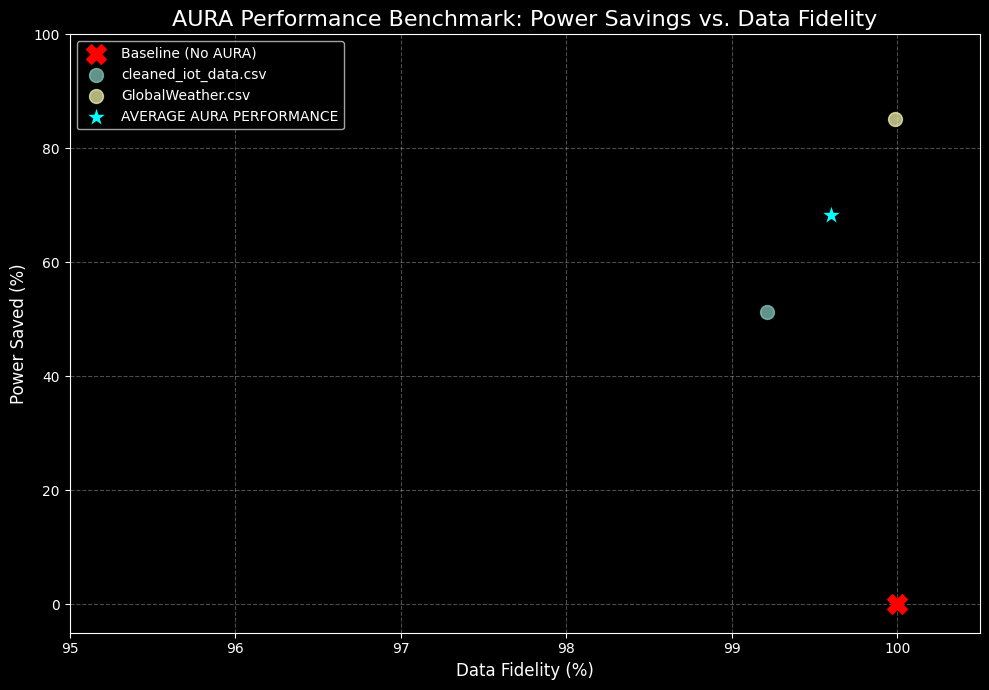